In [116]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import zipfile
    with zipfile.ZipFile('/content/drive/MyDrive/DL Project/DataSet1.zip', 'r') as zip_ref:
        zip_ref.extractall('./DataSet1')
except:
    print("Using Local Machine")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
!git clone https://github.com/ultralytics/yolov5.git
!pip install -r yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
# Include all packages
import os
import gc
import cv2
import shutil
import numpy as np
import pandas as pd
from time import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from yolov5.models.yolo import Model
from sklearn.model_selection import train_test_split

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import deepcopy


In [119]:
def CannyEdge(capturedImage):
    grayScale = cv2.cvtColor(capturedImage, cv2.COLOR_BGR2GRAY)
    constrastKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    topHat = cv2.morphologyEx(grayScale, cv2.MORPH_TOPHAT, constrastKernel)
    blackHat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, constrastKernel)
    grayScale = grayScale + topHat - blackHat
    bilateralFilter = cv2.bilateralFilter(grayScale, 11, 17, 17)
    imageMedian = np.median(capturedImage)
    lowerThreshold = max(0, (0.7 * imageMedian))
    upperThreshold = min(255, (0.7 * imageMedian))
    cannyEdgeImage = cv2.Canny(bilateralFilter, lowerThreshold, upperThreshold)
    cannyEdgeImage = cv2.bitwise_not(cannyEdgeImage)

    cannyEdgeImage = cv2.cvtColor(cannyEdgeImage, cv2.COLOR_GRAY2BGR)
    return cannyEdgeImage

In [120]:
def ResizeImage(image: np.ndarray, x1: int, y1: int, x2: int, y2: int, newWidth: int, newHeight: int) -> tuple:
    originalHeight, originalWidth = image.shape[:2]
    widthScale = newWidth / originalWidth
    heightScale = newHeight / originalHeight
    resizedImage = cv2.resize(
        image, (newWidth, newHeight), interpolation=cv2.INTER_LINEAR)
    x1New, y1New = int(x1 * widthScale), int(y1 * heightScale)
    x2New, y2New = int(x2 * widthScale), int(y2 * heightScale)
    return resizedImage, x1New, y1New, x2New, y2New


In [121]:
def LoadDataSet(dataSetFolderPath: str) -> tuple:
    images = []
    annotations = []
    annotationsFilePath = dataSetFolderPath+"/annotations.csv"
    annotationsDataFrame = pd.read_csv(annotationsFilePath, sep=",")
    uniqueSigns = annotationsDataFrame['class'].unique().tolist()
    for index, row in annotationsDataFrame[1:].iterrows():
        image = cv2.imread(dataSetFolderPath+"/"+row[0])
        images.append(image)
        annotations.append(
            [row[1], row[2], row[3], row[4]])

    del annotationsDataFrame

    return images, annotations, len(uniqueSigns)


In [122]:
def PreProcessDataSet(images: list, annotations: list, batchSize: int, resize: tuple) -> tuple:
    resizedImages = []
    newAnnotations = []
    for i, image in enumerate(images):
        [x1, y1, x2, y2] = annotations[i]
        resizedImage, x1New, y1New, x2New, y2New = ResizeImage(
            image, x1, y1, x2, y2, resize[0], resize[1])
        # resizedImage = CannyEdge(resizedImage)
        resizedImages.append(resizedImage)
        newAnnotations.append(
            [x1New, y1New, x2New, y2New])

    X_train, X_val, y_train, y_val = train_test_split(
        resizedImages, newAnnotations, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val


In [123]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputData, label = self.data[idx]

        if self.transform:
            inputData = self.transform(inputData)
        inputData = torch.from_numpy(inputData).float()
        label = torch.tensor(label).float()
        return inputData, label

def CreateDataLoaders(X_train, X_val, y_train, y_val, batchSize):
    trainDataSet = []
    valDataSet = []
    for i in range(len(X_train)):
        trainDataSet.append((X_train[i], y_train[i]))

    for i in range(len(X_val)):
        valDataSet.append((X_val[i], y_val[i]))

    trainDataSet = CustomDataset(trainDataSet)
    valDataSet = CustomDataset(valDataSet)
    trainDataLoader = DataLoader(
        trainDataSet, batch_size=batchSize, shuffle=True, num_workers=4)
    valDataLoader = DataLoader(
        valDataSet, batch_size=batchSize, shuffle=False, num_workers=4)

    return trainDataLoader, valDataLoader


In [124]:
def CreateYolov5Model(numClasses: int, version: str):
    congfigFile = "yolov5/models/yolov5{}.yaml".format(version)
    model = Model(congfigFile, ch=3, nc=numClasses)
    # model.load_state_dict(torch.load("yolov5{}.pt".format(version))["model"].state_dict(), strict=False)

    return model


In [125]:
def DetectImage(model, inputs, device, conf_thres=0.2, iou_thres=0.5):
    model.eval()

    inputs = torch.tensor(inputs, dtype=torch.float32)
    inputs = inputs.unsqueeze(0)
    inputs = inputs.permute(0, 3, 1, 2)
    inputs = inputs.to(device)
    conf_thres = torch.tensor(conf_thres)
    with torch.no_grad():
        output = model(inputs)
        # max_conf_obj_idx = torch.argmax(output[0][..., 4:5], dim=1)
        # print(int(max_conf_obj_idx))
        # output = output[0][torch.arange(output[0].size(0)), max_conf_obj_idx]
        # output = torchvision.ops.nms(output, conf_thres, iou_thres)
        # max_conf_obj_idx = torch.argmax(output[0][..., 4:5], dim=1)
        # output = output[0][torch.arange(output[0].size(0)), max_conf_obj_idx]
        output = output[0]
        confidences = output[..., 4:5]
        max_confidences, max_indices = torch.max(confidences, dim=1)

        box_coordinates = output[..., :4].view(-1, 4)
        confidence_scores = output[..., 4].view(-1)

        nms_indices = torchvision.ops.nms(box_coordinates, confidence_scores, iou_thres)
        output = output.view(-1, output.shape[-1])[max_indices]
    # Remove the batch dimension
    output = output.squeeze(0)
    return output


In [126]:
batchSize = 32
inputShape = (640, 640)
epochs = 100
numAnchors = 3
yolo5Version = 's'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [127]:
images, annotations, numClasses = LoadDataSet("./DataSet1")
# numClasses = 1

In [128]:
X_train, X_val, y_train, y_val = PreProcessDataSet(
    images, annotations, batchSize, inputShape)
del images
del annotations
gc.collect()

57

In [129]:
# trainDataLoader, valDataLoader = CreateDataLoaders(
#     X_train, X_val, y_train, y_val, batchSize)
# del X_train
# del y_train
# del X_val
# del y_val
gc.collect()

0

In [130]:
yolov5Model = CreateYolov5Model(numClasses,yolo5Version)
yolov5Model = yolov5Model.to(device)


Overriding model.yaml nc=80 with nc=9

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]             

In [131]:
savedModels = [ modelName for modelName in os.listdir('/content/drive/MyDrive/DL Project/Trained Models/') if ('yolov5Modelv2' in modelName)]
savedModels.sort()
print(savedModels[-1])
yolov5Model.load_state_dict(torch.load('/content/drive/MyDrive/DL Project/Trained Models/'+savedModels[-1], map_location=torch.device(device)))


yolov5Modelv204-27-17.pth


<All keys matched successfully>

No. Objects detected: 1
No. Objects detected: 1
No. Objects detected: 2


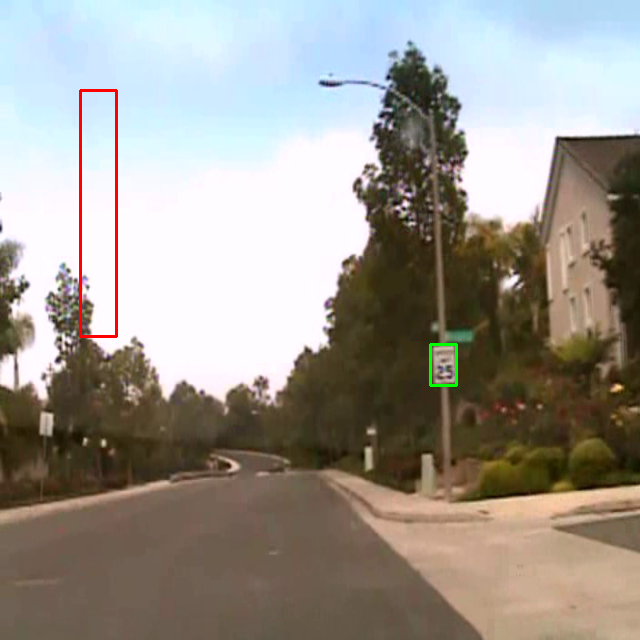

In [133]:
import random
randInt = random.randint(0,len(X_val))

image = X_val[randInt]
image1 = deepcopy(image)
# try:
#     from google.colab.patches import cv2_imshow
#     cv2_imshow(image)
# except:
#     print("using Local")
#     cv2.imshow("Input Image", image)

predictions = DetectImage(yolov5Model, image, device)
[a1,b1,a2,b2] = y_val[randInt]
bBoxs = [[a1,b1,a2,b2]]
machingbBoxes = [[a1,b1,a2,b2]]
albBoxs =[[a1,b1,a2,b2]]
i=0
for pred in predictions:
    
    i+=1
    # print(predictions.shape)
    # for p in pred:
    #   print(int(p))
    # break
    x1, y1, x2, y2, m1,m2 = pred[:6]
    # x2 = x1+x2
    # y2 = y1+y2
    # albBoxs.append( [x1, y1, x1+x2, y2])
    m1,m2, x1, y1, x2, y2= int(m1), int(m2),int(x1), int(y1), int(x2), int(y2)
    # print( m1,m2)
    if(a1 == x1 or a2 == x2 or b1 == y1 or b2 == y2 ):
      if(((x1-x2) >= 17 and (x1-x2) <= 32) and ((y1-y2) >= 31 and (y1-y2)<= 56) ):
        machingbBoxes.append([x1, y1, x2,y2])
      
    # if(abs(x1-x2) >= 17  and abs(y1-y2) >= 31 ):
    if((abs(x1-x2) >= 17 and abs(x1-x2) <= 32) and (abs(y1-y2) >= 31 and abs(y1-y2)<= 56) ):
        bBoxs.append([x1, y1, x2, y2])
    
    # x_center, y_center, width, height =x1, y1, x2, y2
    # x1 = x_center - (width // 2)
    # y1 = y_center - (height // 2)
    # x2 = x_center + (width // 2)
    # y2 = y_center + (height // 2)
    if(abs(x1-x2) >= 17  and abs(y1-y2) >= 31 ):
        albBoxs.append([x1, y1, x2, y2])
    

print("No. Objects detected:" ,len(machingbBoxes) )
print("No. Objects detected:" ,len(bBoxs) )
print("No. Objects detected:" ,len(albBoxs) )
# print("No. Objects detected:" ,len(bBoxs1) )
# print("No. Objects detected:" ,len(bBoxs2) )
# [x1, y1, x2, y2] = bBoxs[0]
# cv2.rectangle(image1, (x1, y1), (x2, y2), (0,255,0), 2)



for bBox in albBoxs[1:]:
    # print(bBox)
    [x1, y1, x2, y2] = bBox
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 2)
for bBox in bBoxs[1:]:
    # print(bBox)
    [x1, y1, x2, y2] = bBox
    cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
for bBox in machingbBoxes[1:]:
    # print(bBox)
    [x1, y1, x2, y2] = bBox
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,0), 2)
cv2.rectangle(image, (a1, b1), (a2, b2), (0,255,0), 2)
try:
    from google.colab.patches import cv2_imshow
    cv2_imshow(image)
except:
    print("using Local")
    cv2.imshow("Input Image", image)



